# Building a BERTweet-Classifier for Hatespeech Classification

In this notebook we build a hate speech classifier based on the data presented in 'Automated Hate Speech Detection and the Problem of Offensive Language' by Davison et al. in 2ß18. The classifier consists of a fully connected layer ont top of a BERTweet model.

The following is based on:
- https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/
- https://xiangyutang2.github.io/tweet-classification/
- https://github.com/t-davidson/hate-speech-and-offensive-language
- https://github.com/VinAIResearch/BERTweet
- https://huggingface.co/vinai/bertweet-base

## Loading all needed Libraries

In [ ]:
! git clone https://github.com/huggingface/transformers.git
! cd transformers
! pip3 install --upgrade transformers
! pip3 install emoji

fatal: destination path 'transformers' already exists and is not an empty directory.
Requirement already up-to-date: transformers in /usr/local/lib/python3.7/dist-packages (4.4.2)


In [ ]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup, AutoModel, AutoTokenizer 
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import re
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
#from classifier import *
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


- Get GPU

In [ ]:
# Get Device 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Used device is {device}')

Used device is cuda:0


- Next we create two folders to save models and data in 


In [ ]:
# Setting up folder to save data and models
! mkdir data
! mkdir models

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘models’: File exists


## Data Exploration and Preprocessing

- Upload data in csv format

In [ ]:
# Loading Data 
df = pd.read_csv("labeled_data.csv")
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


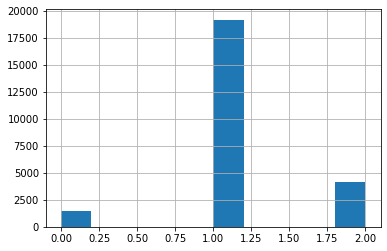

In [ ]:
# Data class distributions
df['class'].hist()

 - We slightly alter prerpocess fucntion from origianl code. Using casual tokenizer from nltk does eitehr keep or remove handles/URLs completely
 We aim to have mentions and links as information for the model. However, as no metadata about users is used, it does not matter who is addressed.
 Thus, replacing all handles and URLs by respective representations will help the model understand better if someone was addressed or not. 

In [ ]:
def anonymize_users_and_links(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URL', parsed_text)
    parsed_text = re.sub(mention_regex, 'USER', parsed_text)
    parsed_text = re.sub('RT', '', parsed_text)
    #parsed_text = parsed_text.code("utf-8", errors='ignore')
    return parsed_text

In [ ]:
# Processing Tweets
df['tweet'] = [anonymize_users_and_links(tweet) for tweet in df['tweet']]
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! USER: As a woman you shouldn't complain a...
1,1,3,0,3,0,1,!!!!! USER: boy dats cold...tyga dwn bad for ...
2,2,3,0,3,0,1,!!!!!!! USER Dawg!!!! USER: You ever fuck a ...
3,3,3,0,2,1,1,!!!!!!!!! USER: USER she look like a tranny
4,4,6,0,6,0,1,!!!!!!!!!!!!! USER: The shit you hear about m...


## Building Bert Classifier Model

### Bert specific processing

In [ ]:
# Here we load a BERTweet specific tokenizer
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", use_fast=False)

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


- Get understanding of the distribution of token sizes for maximal lanrgth used in BERT

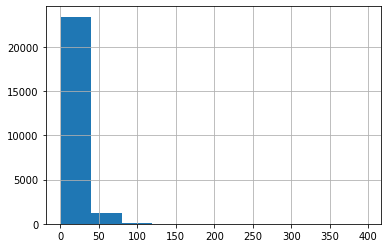

In [ ]:
df['len'] = [len(tokenizer.tokenize(tweet)) for tweet in df['tweet']]
df['len'].hist() 

### Build PyTorch dataset

In [ ]:
# Data Structure
class TweetsDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer, max_len):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.tweets)
    
    def __getitem__(self, item):
        
        tweet = str(self.tweets[item])
        label = self.labels[item]
        
        encoding = tokenizer(tweet,
                             truncation=True,
                             add_special_tokens=True, # Add '[CLS]' and '[SEP]'
                             return_token_type_ids=False,
                             padding = 'max_length',
                             max_length=self.max_len,
                             return_attention_mask=True,
                             return_tensors='pt')
        
        return { 'tweet': tweet, 'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'label': torch.tensor(label, dtype=torch.long)
        }
# Data Loader
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TweetsDataset(
        tweets=df['tweet'].to_numpy(),
        labels=df['class'].to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=2
    )

### Actual Model

In [ ]:
class HSClassifier(nn.Module):
    def __init__(self, n_classes):
        
        super(HSClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/bertweet-base")
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output
        output = self.drop(pooled_output)
        return self.out(output)

## Training the model

### Define Helper functions

In [ ]:
def show_confusion_matrix(confusion_matrix):
  names=['Hate','Offensive','Neither']
  confusion_df = pd.DataFrame(cm, index=names,columns=names)
  plt.figure(figsize=(5,5))
  sns.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
  plt.ylabel(r'True categories',fontsize=14)
  plt.xlabel(r'Predicted categories',fontsize=14)
  plt.tick_params(labelsize=12)
  plt.savefig(f'/content/gdrive/My Drive/HS/data/{NAME}_exp{EXPONENT}_epochs{EPOCHS}_Batchsize{BATCH_SIZE}_confusionmatrix.png')
  plt.show()

In [ ]:
def get_predictions(model, data_loader):
  # put to eval mode to disable dropout 
  model = model.eval()

  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:

      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)

      outputs = model(input_ids=input_ids, attention_mask=attention_mask) #dim BATCH_SIZE x 3
      # torch.max(outputs, dim=1) returns (vals, positions) of maxima -> positions are kept and correspond to class labels
      _, preds = torch.max(outputs, dim=1) # dim BATCH_SIZE x 1

      predictions.extend(preds)
      #prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  #prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, real_values #prediction_probs

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    
    model = model.train()
    losses = []
    correct_predictions = 0
    
    show_every = np.floor(len(data_loader)/5)
    
    for i,d in enumerate(data_loader):
        
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        labels = d["label"].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        # torch.max(outputs, dim=1) returns (vals, positions) of maxima -> positions are kept and correspond to class labels
        _, preds = torch.max(outputs, dim=1)
        
        loss = loss_fn(outputs, labels) # both outputs and labels are in {0,1,2}
        correct_predictions += torch.sum(preds == labels)
        
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
                
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    
    model = model.eval()
    losses = []
    correct_predictions = 0
    
    with torch.no_grad():
        for d in data_loader:
            
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["label"].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())
            
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def get_weights(df, exponent = 1):
    # original balanced weights
    class_weights_balanced = dict(zip([0,1,2],[len(df)/(3*sum(df['class']==i)) for i in range(3)]))

    # Expoentially weighted
    Z = sum(val**exponent for key,val in class_weights_balanced.items())
    class_weights_dict= dict(zip([0,1,2],[(val**exponent)/Z for key,val in class_weights_balanced.items()]))

    # To tensor
    class_weights = torch.tensor([ value for value in class_weights_dict.values()]) 

    return class_weights 

### Parameter choices
- Set hyper parameters and run optimization accordingly

In [ ]:
MAX_LEN = 100 # chosen acccroding to hist above
BATCH_SIZE = 64 # tunable hyper parameter
EPOCHS = 4
EXPONENT = 1
lr = 2e-5
NAME ='BERTweet'

### Optimization 

- Prepare data

In [ ]:
# Splitting data
df_train, df_test = train_test_split(df, test_size=0.2, random_state = 42) 
df_val, df_test = train_test_split(df_test, test_size=0.5,random_state = 42) 

# Create DataLoaders
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

- Initialize model


In [ ]:
# Initialize model
model = HSClassifier(3).to(device)

- Set everything optimization related



In [ ]:
#Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=lr, correct_bias=False)

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps= len(train_data_loader) * EPOCHS
)

#Weights 
class_weights = get_weights(df_train, exponent=EXPONENT)
print('Class weights: ', class_weights)

# The choice of loss is done, as 'This criterion combines LogSoftmax and NLLLoss in one single class'. 
# given input vector softmay is applied, and then NLLL  loss performed
loss_fn = nn.CrossEntropyLoss(weight = class_weights).to(device)

Class weights:  tensor([0.7058, 0.0524, 0.2418])


- Actual optimization procedure

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
      
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
      
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    if val_acc > best_accuracy:
        print(f'Model updated after epoch: {epoch+1} \n')
        torch.save(model.state_dict(), f'models/{NAME}_exp{EXPONENT}_epochs{EPOCHS}_BatchSize{BATCH_SIZE}_best_model_state.bin')
        best_accuracy = val_acc


Epoch 1/4
----------


KeyboardInterrupt: ignored

## Model Evaluation

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])
#plt.yscale('log')
plt.show()

- Next we load our best model, as the current state might have overfitted

In [ ]:
# load best model from optimization
model = HSClassifier(3)
model.load_state_dict(torch.load(f'models/{NAME}_exp{EXPONENT}_epochs{EPOCHS}_BatchSize{BATCH_SIZE}_best_model_state.bin'))
model = model.to(device)

In [ ]:
# Test Accuracy
test_acc, _ = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
print(f'Test Accuracy: {test_acc.item()}')

- Calculate Scores 

In [ ]:
# Calculation of relevant scores
y_pred, y_test = get_predictions(model, test_data_loader)
report = classification_report(y_test, y_pred, target_names=['HS', 'OL', 'NE'], output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(f'/content/gdrive/My Drive/HS/data/{NAME}_exp{EXPONENT}_epochs{EPOCHS}_BatchSize{BATCH_SIZE}_Report.csv') 

report_df

In [ ]:
cm = confusion_matrix(y_test, y_pred, normalize = 'true')
show_confusion_matrix(cm)

In [ ]:
from google.colab import files
files.download("data")
files.download("models")

In [ ]:
model_save_name = f'models/{NAME}_exp{EXPONENT}_epochs{EPOCHS}_BatchSize{BATCH_SIZE}_best_model_state.bin'
path = f"/content/gdrive/My Drive/HS/{model_save_name}" 
torch.save(model.state_dict(), path)